In [1]:
import ee
import geemap 
from landsatxplore.api import API

In [2]:
ee.Authenticate()


Successfully saved authorization token.


In [44]:
ee.Initialize()

In [102]:
Map = geemap.Map()


In [232]:
#image = ee.Image('LANDSAT/LE7_TOA_5YEAR/1999_2003')
dataset_landsat = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2').filterDate('2023-09-01', '2023-10-01')


landsat_vis = {'bands': ['B4', 'B3', 'B2'], 'gamma': 1.4}
landsat_vis_new_red = {'bands': ['SR_B4'], 'gamma': 1.4,'min': 0.0,'max': 0.3}
landsat_vis_new_nir = {'bands': ['SR_B5'], 'gamma': 1.4,'min': 0.0,'max': 0.3}

#Map.addLayer(image, landsat_vis, "LE7_TOA_5YEAR/1999_2003", True, 0.7)
Map.addLayer(dataset_landsat, landsat_vis_new_red, "LC09/C02/T1_L2", True, 0.7)

In [210]:
#Map

In [256]:
# Draw any shapes on the map using the Drawing tools before executing this code block
feature = Map.draw_last_feature

if feature is None:
    geom = ee.Geometry.Polygon(
        [
            [
                [15.31,54.05],
                [15.31,54.1],
                [15.36,54.1],
                [15.36,54.05],
                [15.31,54.05],
            ]
        ]
    )
    feature = ee.Feature(geom, {})

roi = feature.geometry()

In [257]:
image=dataset_landsat.mean()
image_new = image.clip(roi).unmask()
geemap.ee_export_image(
    image_new, filename='mapa_new_red.tif', scale=90, region=roi, file_per_band=True
)

Generating URL ...
Please wait ...
Data downloaded to c:\Users\pawel\Pulpit\Projekty\Sentinel


In [219]:
image = ee.Image('LANDSAT/LE7_TOA_5YEAR/1999_2003')
Map = geemap.Map(zoom=16)

Map.set_center(15.386136194516476,54.08756365231493)
Map.add_layer(geom_samowo,{'color': 'blue'})


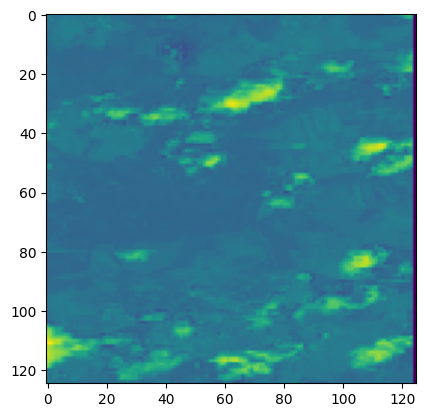

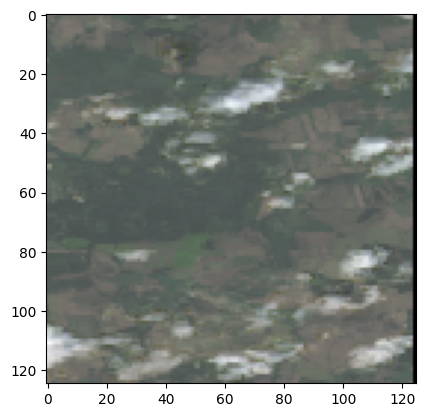

In [4]:
import rasterio
from rasterio.plot import show
import numpy as np  
import matplotlib.pyplot as plt

raster = rasterio.open('mapa_new_nir.tif')

def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

nir = raster.read(4)
red = raster.read(3)
green = raster.read(2)

# Normalize band DN
nir_norm = normalize(nir)
red_norm = normalize(red)
green_norm = normalize(green)


# Stack bands
nrg = np.dstack((nir_norm, red_norm, green_norm))

show(green_norm)
plt.imshow(nrg)

In [3]:
# NDVI calculate 

band_red = rasterio.open('mapa_new_red.SR_B4.tif')
band_nir  = rasterio.open('mapa_new_red.SR_B5.tif')

band_nir.crs 
#show(band_red)

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
show(band_red,ax=ax1)
show(band_nir,ax=ax2)

NameError: name 'rasterio' is not defined

In [2]:
red = band_red.read(1).astype('float64')
nir = band_nir.read(1).astype('float64')

ndvi = np.where( 
    (nir+red)==0.,
    0,
    (nir-red)/(nir+red)
)

show(ndvi) 

NameError: name 'band_red' is not defined